In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
import joblib
#from sklearn.externals import joblib ---> DEPRECATED

import os

%matplotlib inline

See how to install `pandas_profiling` [here](https://anaconda.org/conda-forge/pandas-profiling).

More on `pandas_profiling` [here](https://github.com/pandas-profiling/pandas-profiling).

### Some explorative, some preprocessing and some visuliazation

In [2]:
df = pd.read_json('amsterdam.json')
df = df.dropna()

In [3]:
#gmaps.configure(api_key="blablabla")

In [4]:
df.price.head()

0    $145.00
1     $88.00
2    $130.00
3    $110.00
4    $115.00
Name: price, dtype: object

Let's have a look at the dataset by using a very helpful took to describe dataframes: pandas_profiling. 


In [5]:
#df.profile_report(style={'full_width': False})
df.profile_report()

As describe from the report the dataset containes 14 variables, 10 are numeric and 2 categorical (we will _probably_ need to get dummy variables for those when modelling). Moreover, according to the report variable host_listings_count and calculated_host_listings_count are highly correlated with a pearson score of 0.94, hence we will discard the former to avoid multicollinearity problems. (https://en.wikipedia.org/wiki/Multicollinearity)

In [6]:
df = df.drop('host_listings_count', axis=1)

However it seems that our target variable is recognised as categorical instead of numerical:

In [7]:
df['price'].head()

0    $145.00
1     $88.00
2    $130.00
3    $110.00
4    $115.00
Name: price, dtype: object

We can see that our target value (price) is not in a numerical format, hence we must convert it, let's have a look to the longest one, in order to nudesrand if there are any formatting applied that needs to be removed before converting:

In [8]:
max(df['price'].values, key = len)

'$1,305.00'

First of all we can see our target variable has 2 different characters we need to get rid off: the $ symbol and the comma indetifying the thousands.

In [9]:
df['price'] = df['price'].apply(lambda x: x.replace('$', ''))
df['price'] = df['price'].apply(lambda x: x.replace(',', ''))

df['price'] = pd.to_numeric(df['price'])

The dataset has two columns containing informations about coordinates where the flat is located, plus we have our target variable. Hence we can create a heatmap to better undertsand where flat are located and how the price is affected by the location

TO achieve we will use `gmaps`, a python package to create interactive maps using Google Maps.

You can use the free version, without an API key, however you will get maps with an ugly 'for developement purporses only' watermark, if you want to get rid of those watermarks you can register (by adding a credit card) to Google Cloud Platform and claim free credits.

You can install it on jupyter notebook by first enabling via terminal ipywidgets widgets extensions:

`jupyter nbextension enable --py --sys-prefix widgetsnbextension`

then

`pip install gmaps`

and finally load the extension with:

`jupyter nbextension enable --py --sys-prefix gmaps`

Create heatmaps with gmaps is simple, we specify a Map object and then pass our dataframe with coordinateds ands weigths.

In [10]:
amsterdam = {'lat' : 52.3667, 'long' : 4.8945}

In [11]:
import gmaps

In [12]:
fig = gmaps.Map(layout={'width': '1000px', 'height': '500px', 'padding': '10px'})

fig.add_layer(gmaps.heatmap_layer(df[['latitude', 'longitude']],
         weights=df['price']))

fig

Map(configuration={'api_key': None}, data_bounds=[(52.33386162007987, 4.819224950353657), (52.396834438348804,…

N.B if you installed gmaps, and did everything correctly, but the map doesn't show up, just restart jupyter notebook and it will probably work!

(**MUST restart Jupyter server!**)

The map, shows that locations in the city centre are more expensive, while the outskirts are cheaper (a pattern that probably not only exists in Amsterdam). In addition, the city centre seems to have its own pattern.

I order to capture some geographical pattern we need to apply some feature engineering, a nice approach is to find a list of point of interest (POI) and calculate the distance between each observation and the POI.

To calculate the distance in Km I am using a function that retrieves the haversine distance, AKA the distance between two points on a sphere. 
This kind of metrics has its own pros and cons: it gives an easy way to calculate the distance between two poinys, but it does not take into account abstacles such as building, lakes, rivers, borders and so on.

But to calculate this we first need a list of POI, aka let's search on Google:
https://www.google.com/travel/things-to-do?g2lb=2502405,2502548,4208993,4254308,4258168,4260007,4270442,4274032,4285990,4289525,4291318,4301054,4305595,4308216,4308984,4313006,4314846,4315873,4317816,4317915,4322164,4324293,4326405,4328159,4329288,4334343,4270859,4284970,4291517,4292955,4316256,4333108&hl=en&gl=it&un=1&otf=1&dest_mid=/m/0k3p&dest_src=ts&dest_state_type=main&sa=X&ved=2ahUKEwia8YDz-cPmAhXQzqQKHeyrCKwQ6tEBKAQwAHoECA0QCw

For each of them I searched the coordinates and created a pandas DataFrame:

In [13]:
names = ["van_gogh_museum", "anne_frank_house", "dam_sqaure",
    "rijksmuseum", "vondelpark", "jordaan", "heineken", 
    "royal_palace", "rembrandt_museum", "schiphol", "leidseplein"]

lat = [52.3584, 52.3752, 52.3731, 52.3600, 52.3580, 52.3739, 52.3578,
      52.3732, 52.3694, 52.3105, 52.365051]

long = [ 4.8811, 4.8840, 4.8926, 4.8852, 4.8686, 4.8809, 4.8918,
        4.8914, 4.9012, 4.7683, 4.884429]

poi = pd.DataFrame({'lat': pd.Series(lat, index=names), 
      'long': pd.Series(long, index=names)})
print(poi)

                        lat      long
van_gogh_museum   52.358400  4.881100
anne_frank_house  52.375200  4.884000
dam_sqaure        52.373100  4.892600
rijksmuseum       52.360000  4.885200
vondelpark        52.358000  4.868600
jordaan           52.373900  4.880900
heineken          52.357800  4.891800
royal_palace      52.373200  4.891400
rembrandt_museum  52.369400  4.901200
schiphol          52.310500  4.768300
leidseplein       52.365051  4.884429


The I we can define our function to calculate the distance:

In [14]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

More about the haversine formula [here](https://en.wikipedia.org/wiki/Haversine_formula).

And finally iterate over each rotw of the dataset and add 11 columns describing the distance from the previously mentioned POIs,

Now we can iterate each row of the dataset, and for each of them we iterate through our POI dataframe and calculate distance for each POI
(Did I say too many times "for each"?)

In [15]:
for index, row in df.iterrows():
    for point, coordinates in poi.iterrows():
        df.loc[index, point] = haversine(coordinates['long'],
                                         coordinates['lat'], row['longitude'], row['latitude'])

Let's now plot again our map with POIs, we can do this by iterating over each rows of the `poi` dataframe and creating a tuple:

In [16]:
fig.add_layer(gmaps.symbol_layer([tuple(x) for x in poi.to_numpy()]
                                 , fill_color='green', stroke_color='green'))
fig

Map(configuration={'api_key': None}, data_bounds=[(52.32654364848272, 4.80582242013719), (52.396834438348804, …

From the visualization it can be possible to see that near the Willemspark there are much less flats than compared to areas around, in addition most of the POIs are located in 'expensive' areas, especially around Dam Sqaure's district.

------------------------------------------------------------------------------

### Modelling

Let's now start the modelling section, we will prepare our dataset by encoding the categorical variable 'room_type' and by splitting it into train, test and validation.

In [18]:
df = pd.get_dummies(df)

In [19]:
df

,accommodates,bathrooms,bedrooms,guests_included,minimum_nights,number_of_reviews,calculated_host_listings_count,price,latitude,longitude,...,heineken,royal_palace,rembrandt_museum,schiphol,leidseplein,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t
0,6,1.0,2.0,1,3,4,1,145.0,52.361173,4.866755,...,1.740539,2.140720,2.509755,8.740716,1.274440,1,0,0,1,0
1,2,1.0,1.0,1,2,17,1,88.0,52.370237,4.859507,...,2.590750,2.188747,2.830370,9.078094,1.786520,1,0,0,1,0
2,2,1.0,1.0,2,2,4,1,130.0,52.362016,4.866872,...,1.755353,2.077113,2.469611,8.807370,1.238186,1,0,0,1,0
3,4,1.0,2.0,2,4,2,2,110.0,52.365826,4.858178,...,2.449751,2.398419,2.946034,8.662530,1.783358,1,0,0,1,0
4,2,1.0,1.0,1,3,10,1,115.0,52.364179,4.864885,...,1.959269,2.059492,2.531484,8.865087,1.329737,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15176,4,1.5,1.0,2,1,0,1,80.0,52.391679,4.779126,...,8.520760,7.887468,8.642738,9.050862,7.731908,0,1,0,0,1
15177,2,1.0,1.0,2,3,0,1,125.0,52.395505,4.878143,...,4.291235,2.636760,3.295699,12.033971,3.411016,1,0,0,0,1
15178,16,2.0,0.0,10,2,0,1,435.0,52.426224,4.959300,...,8.875138,7.477563,7.442663,18.257174,8.484441,1,0,0,0,1
15179,4,1.5,2.0,2,3,0,1,80.0,52.354298,4.974295,...,5.612470,6.004523,5.236548,14.810886,6.214696,1,0,0,1,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15148 entries, 0 to 15180
Data columns (total 26 columns):
accommodates                      15148 non-null int64
bathrooms                         15148 non-null float64
bedrooms                          15148 non-null float64
guests_included                   15148 non-null int64
minimum_nights                    15148 non-null int64
number_of_reviews                 15148 non-null int64
calculated_host_listings_count    15148 non-null int64
price                             15148 non-null float64
latitude                          15148 non-null float64
longitude                         15148 non-null float64
van_gogh_museum                   15148 non-null float64
anne_frank_house                  15148 non-null float64
dam_sqaure                        15148 non-null float64
rijksmuseum                       15148 non-null float64
vondelpark                        15148 non-null float64
jordaan                           15148 non-nu

By calling the get_dummies function the column room_type has been splitted in 3 columns: each one corresponding to one of the categories, then a number is being assigned: 1 if the observation falls into this category, 0 if it doesnt.

Finally, we can split out dataset between our predictors and target values, and eventually into train, test and validation, using `train_test_split` twice. It returns a 60% - 20% - 20% partition.

In [21]:
X = df.drop(['price'], axis=1)
y = df['price']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


The first model used will be used as a baseline, and it will be a classical linear regression, evaluated with cross validation using the `GridSearchCV` class on r2 and MAE metrics.

let's fit it with both datasets and evaluate it:

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

We can now calculare our r2 and MAE errors:

In [24]:
from sklearn import metrics

r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)

scores = pd.DataFrame({'Baseline (regression)' : [r2, mae]}, index=['R2', 'MAE'])

scores

,Baseline (regression)
R2,0.408215
MAE,36.953694


Let's now plot the difference of test set and predicted value against our test set, this to have a better idea on how the regression model worked:

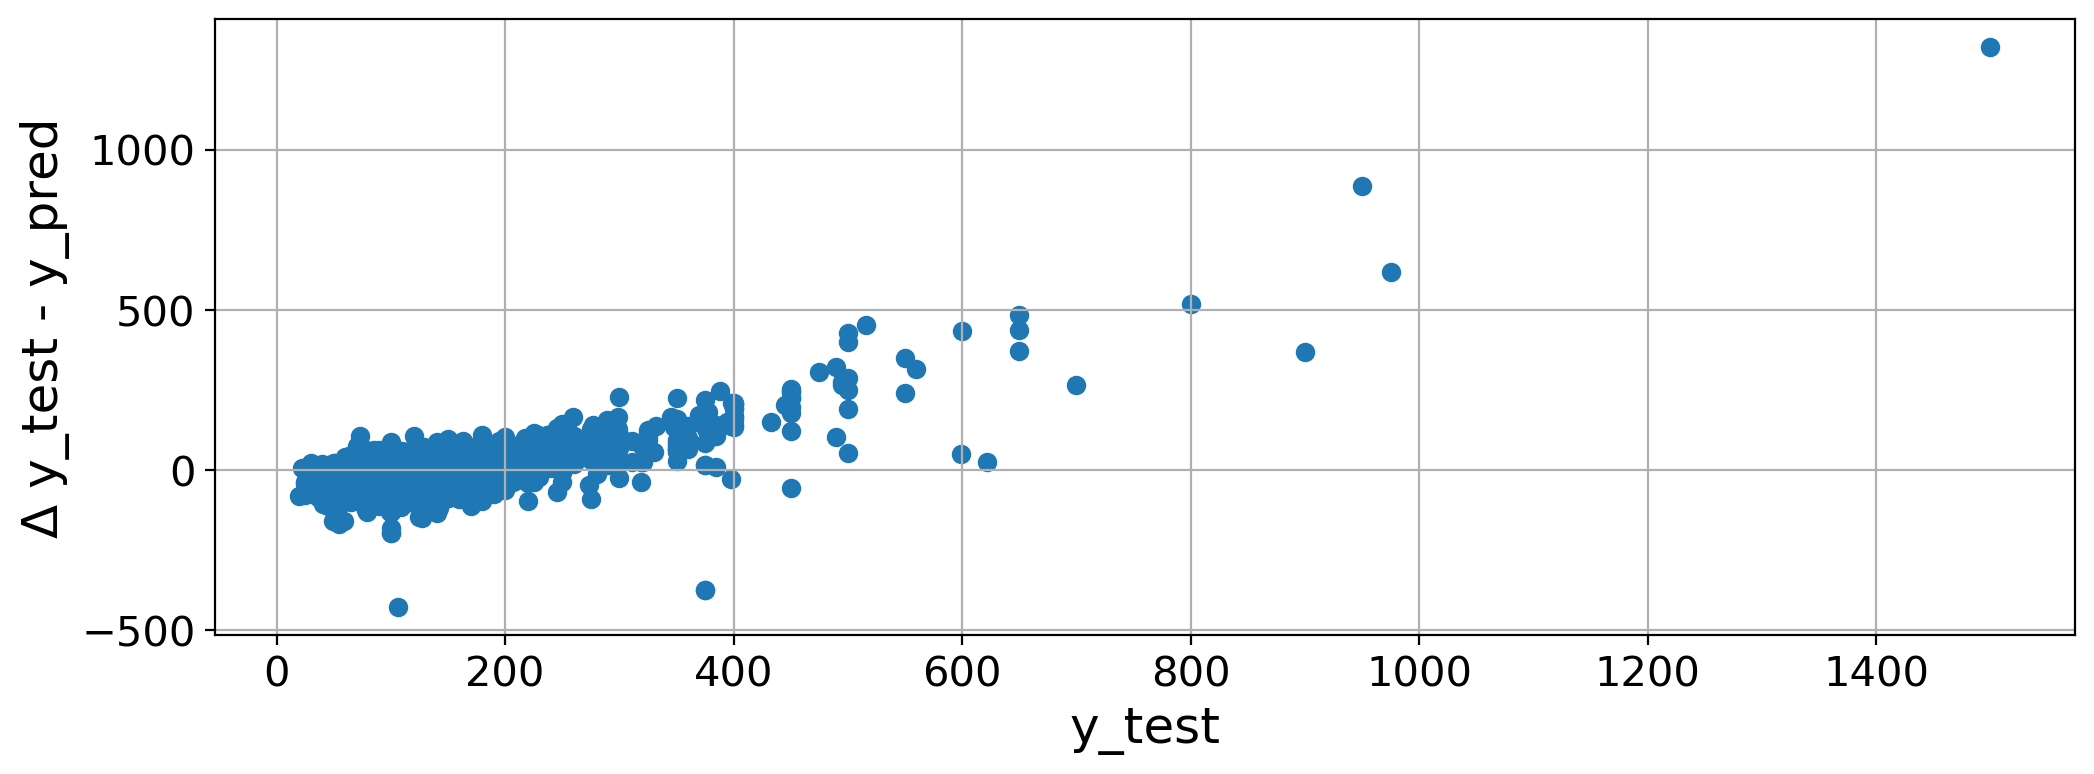

In [25]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize=(12, 4), dpi=200)
plt.scatter(y_test, (y_test - y_pred))

plt.tick_params(labelsize=15)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('Δ y_test - y_pred', fontsize=18)
plt.grid()

The next model has been chosen according to the sklearn map https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html, and it constists in a Support Vector Regressor. However, since playing with parameters its not always easy, and it might require specific knowledge `GridSearchCV` will come in help:

In [26]:
if 'svr_gridsearch_cv.pkl' in os.listdir():
    
    svr_grid_search = joblib.load('svr_gridsearch_cv.pkl')
    
else:
    
    from sklearn.svm import SVR

    svr = SVR()

    param_grid = [
      {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}]

    svr_grid_search = GridSearchCV(svr, param_grid=param_grid, 
                                   n_jobs=-1, 
                                   scoring=['r2', 'neg_mean_squared_error'],
                                  refit='neg_mean_squared_error', verbose=100)

    svr_grid_search.fit(X_train, y_train)

    joblib.dump(svr_grid_search.best_estimator_, 'svr_gridsearch_cv.pkl')

Be careful, this tasks can take up to 40 minutes, that's why before fitting I check if the model already exists from a previous fit, and if exists, I load it.

We will then, again, predict and calculare our metrics based on the best paramters from `GridSearchCV`

In [27]:
y_pred_svr = svr_grid_search.predict(X_test)

r2 = metrics.r2_score(y_test, y_pred_svr)
mae = metrics.mean_absolute_error(y_test, y_pred_svr)

scores['SVR'] = [r2, mae] 

scores

,Baseline (regression),SVR
R2,0.408215,0.429339
MAE,36.953694,33.727592


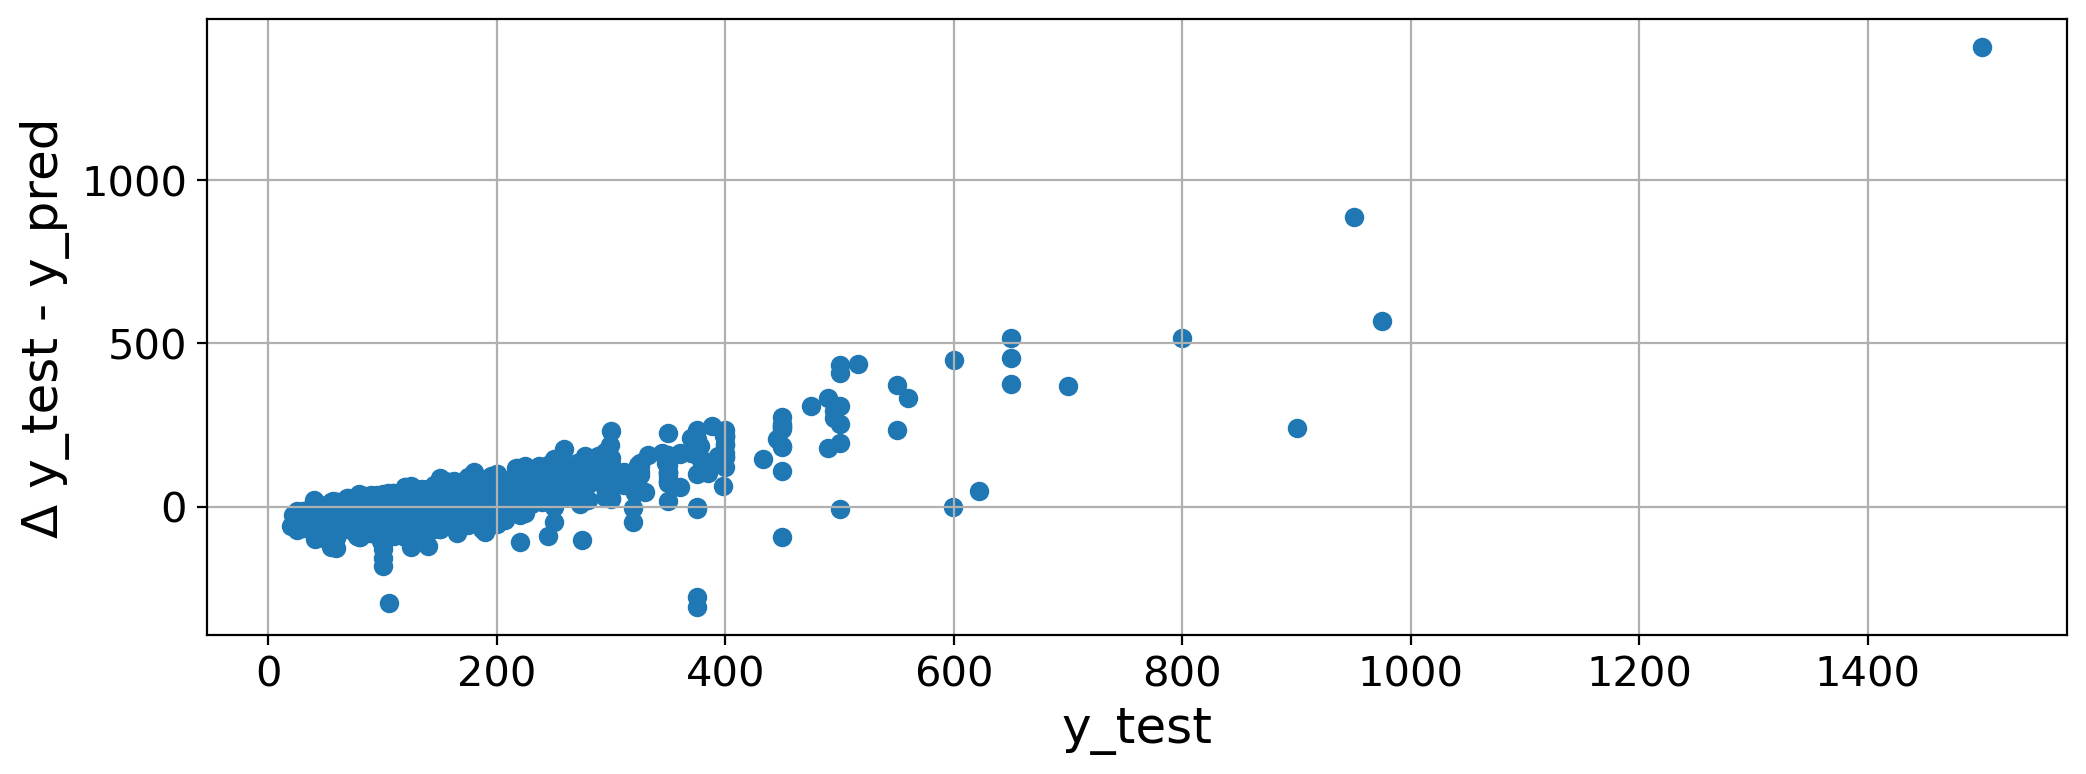

In [28]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize=(12, 4), dpi=200)
plt.scatter(y_test, (y_test - y_pred_svr))

plt.tick_params(labelsize=15)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('Δ y_test - y_pred', fontsize=18)
plt.grid()

The third model we will test is based on Stochastic Gradient Descent, I will use LightGBM, a library by Microsoft which is widely used in the industry and is one of the most used libraries to win Kaggle competitions

To install the package `lightgbm`, see [this link](https://anaconda.org/conda-forge/lightgbm).

In [31]:
if 'gbm_gridsearch_cv.pkl' in os.listdir():
    
    gbm_grid_search = joblib.load('gbm_gridsearch_cv.pkl')
    
else:
    
    from lightgbm import LGBMRegressor


    gbm = LGBMRegressor()

    param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 150],
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [15, 31, 50]}

    gbm_grid_search = GridSearchCV(gbm, param_grid=param_grid, 
                                   n_jobs=-1, 
                                   scoring=['r2', 'neg_mean_squared_error'],
                                  refit='neg_mean_squared_error', verbose=100)

    gbm_grid_search.fit(X_train, y_train)

    joblib.dump(gbm_grid_search.best_estimator_, 'gbm_gridsearch_cv.pkl')

In [32]:
y_pred_gbm = gbm_grid_search.predict(X_test)

r2 = metrics.r2_score(y_test, y_pred_gbm)
mae = metrics.mean_absolute_error(y_test, y_pred_gbm)

scores['GBM'] = [r2, mae] 

scores

,Baseline (regression),SVR,GBM
R2,0.408215,0.429339,0.470584
MAE,36.953694,33.727592,34.254885


So far the best performing model is the GBM, which increases the R2 by 6% but, can we further improve it?

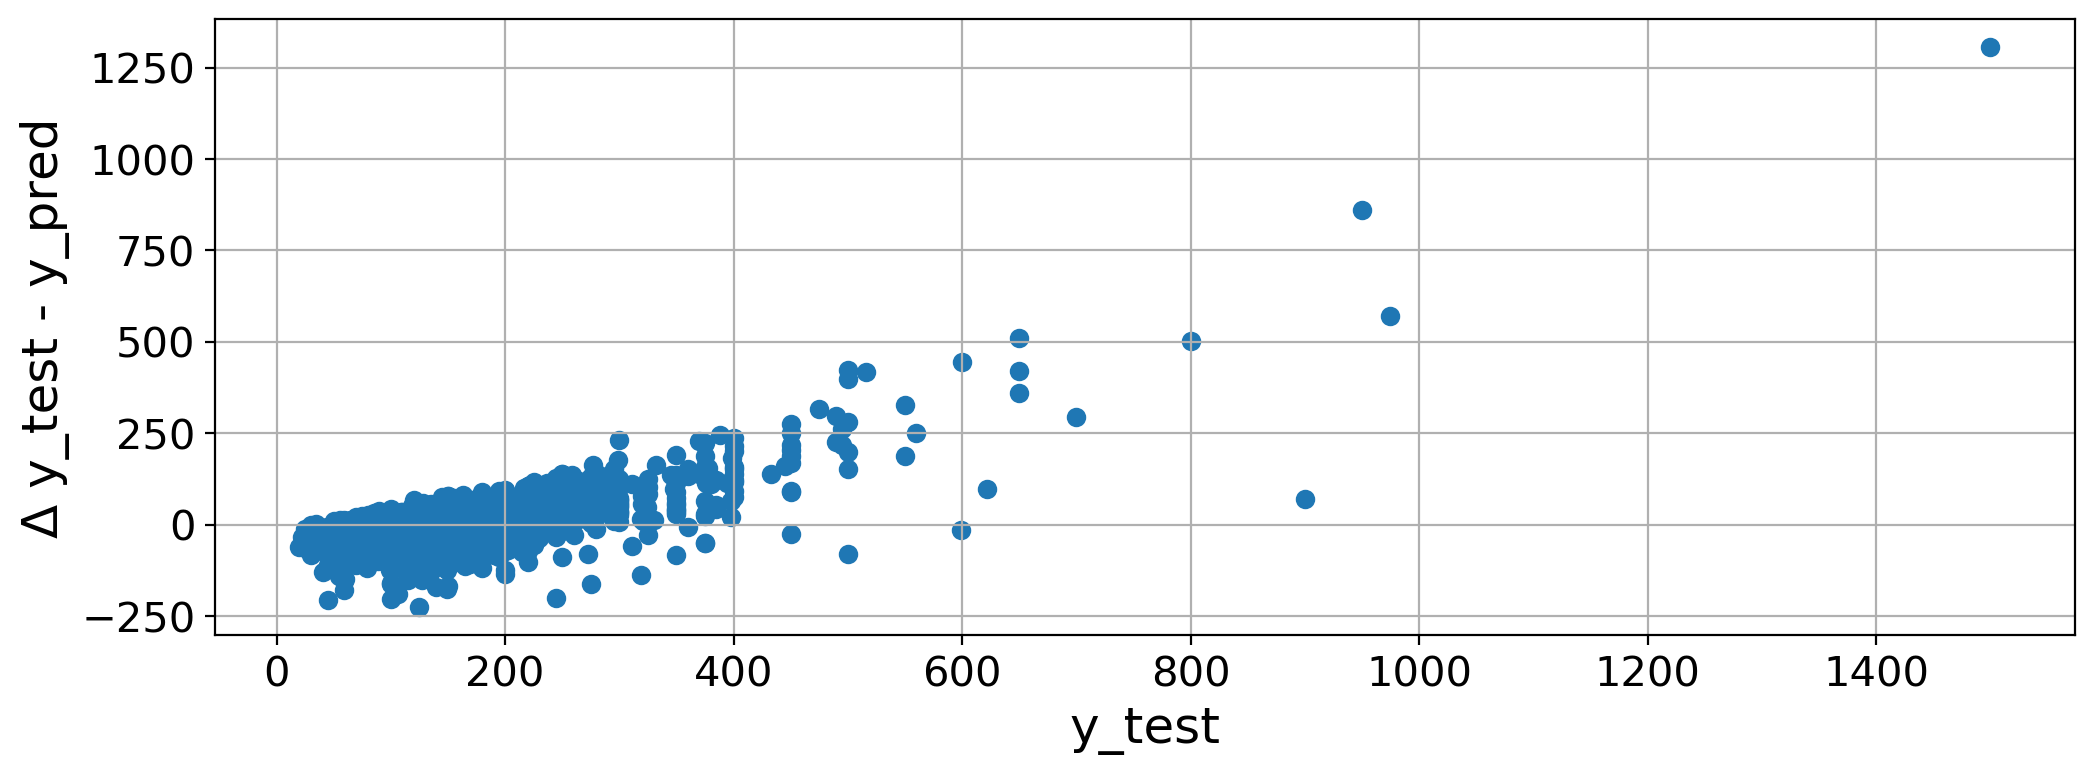

In [33]:
plt.figure(figsize=(12, 4), dpi=200)
plt.scatter(y_test, (y_test - y_pred_gbm))


plt.tick_params(labelsize=15)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('Δ y_test - y_pred', fontsize=18)
plt.grid()

# Neural network

To install `tensorflow`, see [this link](https://anaconda.org/conda-forge/tensorflow).

To install `keras`, see [this link](https://anaconda.org/conda-forge/keras).

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(25,)),  
    layers.Dropout(0.2), 
    layers.Dense(128),
    layers.Dropout(0.2), 
    layers.Dense(1, activation='linear')
  ])

    optimizer = 'adam'

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mae', r2_keras])
    return model

Using TensorFlow backend.


In [37]:
from keras.wrappers.scikit_learn import KerasRegressor

regressor = KerasRegressor(build_fn=build_model, batch_size=256, epochs=100)

In [38]:
model = build_model()

history = regressor.fit(np.asarray(X_train), np.asarray(y_train))

Train on 12118 samples
Epoch 1/100
12118/12118 [==============================] - 1s 76us/sample - loss: 13747.9898 - mae: 79.5900 - r2_keras: -1.0036
Epoch 2/100
12118/12118 [==============================] - 0s 7us/sample - loss: 7495.5807 - mae: 52.5731 - r2_keras: -0.0110
Epoch 3/100
12118/12118 [==============================] - 0s 7us/sample - loss: 6846.1761 - mae: 49.5306 - r2_keras: 0.0952
Epoch 4/100
12118/12118 [==============================] - 0s 7us/sample - loss: 6318.1042 - mae: 47.0149 - r2_keras: 0.1696
Epoch 5/100
12118/12118 [==============================] - 0s 7us/sample - loss: 5782.0112 - mae: 44.5200 - r2_keras: 0.2527
Epoch 6/100
12118/12118 [==============================] - 0s 7us/sample - loss: 5361.3480 - mae: 41.8594 - r2_keras: 0.3167
Epoch 7/100
12118/12118 [==============================] - 0s 7us/sample - loss: 4966.2300 - mae: 39.7138 - r2_keras: 0.3663
Epoch 8/100
12118/12118 [==============================] - 0s 7us/sample - loss: 4763.7125 - mae: 

12118/12118 [==============================] - 0s 7us/sample - loss: 4170.8681 - mae: 35.5490 - r2_keras: 0.4604
Epoch 66/100
12118/12118 [==============================] - 0s 7us/sample - loss: 4248.6675 - mae: 35.4051 - r2_keras: 0.4647
Epoch 67/100
12118/12118 [==============================] - 0s 7us/sample - loss: 4169.5698 - mae: 35.6097 - r2_keras: 0.4638
Epoch 68/100
12118/12118 [==============================] - 0s 7us/sample - loss: 4164.3195 - mae: 35.5048 - r2_keras: 0.4575
Epoch 69/100
12118/12118 [==============================] - 0s 8us/sample - loss: 4105.7502 - mae: 35.2290 - r2_keras: 0.4708
Epoch 70/100
12118/12118 [==============================] - 0s 8us/sample - loss: 4158.0814 - mae: 35.0487 - r2_keras: 0.4714
Epoch 71/100
12118/12118 [==============================] - 0s 8us/sample - loss: 4193.0957 - mae: 35.1781 - r2_keras: 0.4798
Epoch 72/100
12118/12118 [==============================] - 0s 8us/sample - loss: 4152.2828 - mae: 35.3710 - r2_keras: 0.4707
Epoch

In [39]:
y_pred_NN = regressor.predict(X_test)

r2 = metrics.r2_score(y_test, y_pred_NN)
mae = metrics.mean_absolute_error(y_test, y_pred_NN)

scores['NN'] = [r2, mae] 

scores

,Baseline (regression),SVR,GBM,NN
R2,0.408215,0.429339,0.470584,0.448255
MAE,36.953694,33.727592,34.254885,34.779569


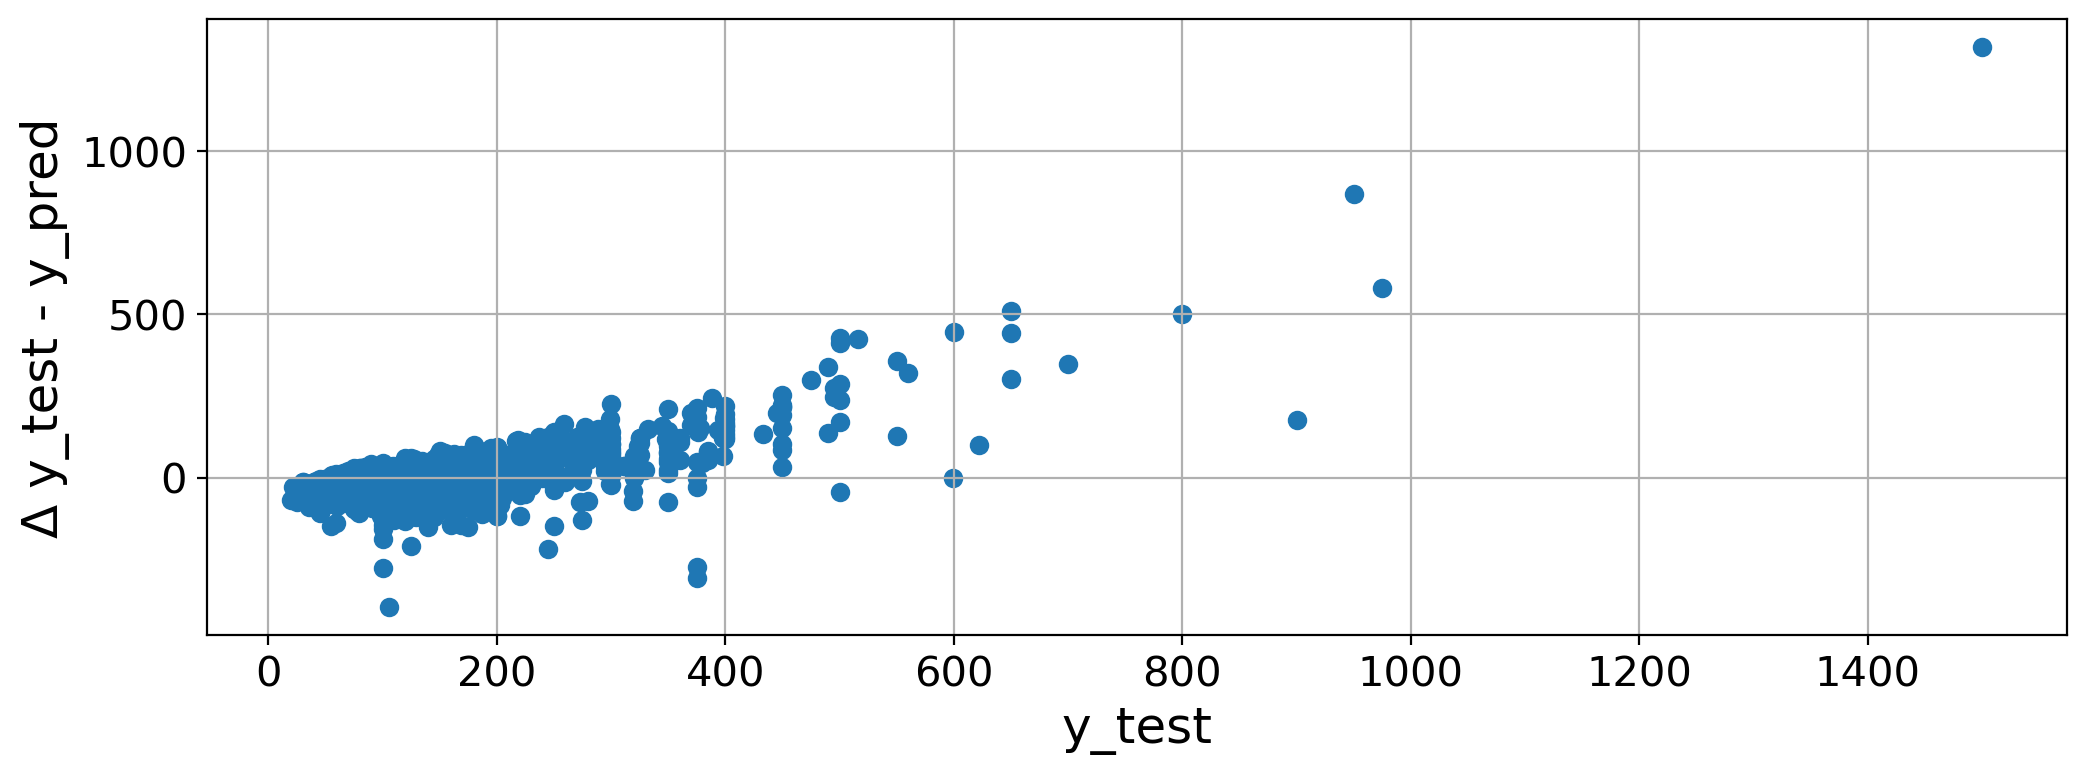

In [40]:
plt.figure(figsize=(12, 4), dpi=200)
plt.scatter(y_test, (y_test - y_pred_NN))


plt.tick_params(labelsize=15)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('Δ y_test - y_pred', fontsize=18)
plt.grid()

In [41]:
coefficients = pd.concat([pd.DataFrame(X.columns, columns=['variable']), 
                          pd.DataFrame(np.transpose(lin_reg.coef_), 
                                       columns=['coefficients'])], axis = 1)
coefficients

,variable,coefficients
0,accommodates,20.128636
1,bathrooms,24.672852
2,bedrooms,18.951747
3,guests_included,2.975543
4,minimum_nights,-0.099977
5,number_of_reviews,-0.083748
6,calculated_host_listings_count,0.519760
7,latitude,-714.917625
8,longitude,-105.974315
9,van_gogh_museum,-17.280392
